**Some vehicles stopped in violation are exempt from fines due to business reasons. For vehicles that are exempt, are there repeat offenders? Where are exempt vehicles frequently in violation?**

*Recommendation - This problem is great for a mapping visualization! Choose a CUNY bus route that you are familiar with plot the long and latitude of where vehicles are in violation as well as the overall bus route.*

## Data Extraction via API

In [8]:
import requests
import random
import logging
import time
import csv
import pandas as pd
import os
import io

DATA_DIR_RAW = os.path.join("..", "..", "data", "raw")
DATA_DIR_PROCESSED = os.path.join("..", "..", "data", "processed")

# 🪵 Logging setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

In [9]:
def write_to_csv(data, output_file, replace=False):
    if os.path.exists(output_file) and not replace:
        logging.info(f"☑️ File '{output_file}' already exists. Skipping write.")
        return

    try:
        if isinstance(data, pd.DataFrame):
            # Handle DataFrame directly
            if data.empty:
                logging.warning("⚠️ No data to write (DataFrame is empty).")
                return
            data.to_csv(output_file, index=False, encoding="utf-8")
            logging.info(f"📄 Successfully wrote {len(data)} rows (DataFrame) to '{output_file}'")

        elif isinstance(data, list):
            # Handle list of dicts
            if not data:
                logging.warning("⚠️ No data to write (list is empty).")
                return
            fieldnames = sorted(set().union(*(d.keys() for d in data)))
            with open(output_file, mode="w", newline="", encoding="utf-8") as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(data)
            logging.info(f"📄 Successfully wrote {len(data)} rows (list of dicts) to '{output_file}'")

        else:
            logging.error(f"❌ Unsupported data type: {type(data)}. Expected DataFrame or list of dicts.")

    except Exception as e:
        logging.error(f"❌ Failed to write CSV: {e}")

In [11]:
ACE_endpoint_url = "https://data.ny.gov/resource/kh8p-hcbm.csv"

exempt_types = (
    "'EXEMPT - BUS/PARATRANSIT', "
    "'EXEMPT - OTHER', "
    "'EXEMPT - EMERGENCY VEHICLE', "
    "'EXEMPT - COMMERCIAL UNDER 20'"
)

count_query = f"""
    SELECT count(*)
    WHERE violation_status IN ({exempt_types})
"""
response = requests.get(ACE_endpoint_url, params={"$query": count_query})

# Fix: parse the count
count_df = pd.read_csv(io.StringIO(response.text))
max_rows = int(count_df.iloc[0, 0])
print(f"Total exempt rows available: {max_rows}")

all_data = []
limit = 50000
offset = 0

while offset < max_rows:
    print(f"Fetching rows {offset + 1} to {min(offset + limit, max_rows)}")

    soql_query = f"""
        SELECT *
        WHERE violation_status IN ({exempt_types})
        LIMIT {limit}
        OFFSET {offset}
    """

    response = requests.get(ACE_endpoint_url, params={"$query": soql_query})

    try:
        chunk_data = pd.read_csv(io.StringIO(response.text))
        if not chunk_data.empty:
            all_data.append(chunk_data)
    except pd.errors.EmptyDataError:
        break

    offset += limit
    time.sleep(1)

ACE_exempt_violations = pd.concat(all_data, ignore_index=True)
print(f"Total rows collected: {len(ACE_exempt_violations)}")

Total exempt rows available: 870810
Fetching rows 1 to 50000
Fetching rows 50001 to 100000
Fetching rows 100001 to 150000
Fetching rows 150001 to 200000
Fetching rows 200001 to 250000
Fetching rows 250001 to 300000
Fetching rows 300001 to 350000
Fetching rows 350001 to 400000
Fetching rows 400001 to 450000
Fetching rows 450001 to 500000
Fetching rows 500001 to 550000
Fetching rows 550001 to 600000
Fetching rows 600001 to 650000
Fetching rows 650001 to 700000
Fetching rows 700001 to 750000
Fetching rows 750001 to 800000
Fetching rows 800001 to 850000
Fetching rows 850001 to 870810
Total rows collected: 870810


In [12]:
OUTPUT_ACE = os.path.join(DATA_DIR_RAW, "ACE_exempt_violations.csv")
write_to_csv(ACE_exempt_violations, OUTPUT_ACE)

2025-09-21 19:00:04,590 - INFO - 📄 Successfully wrote 870810 rows (DataFrame) to '..\..\data\raw\ACE_exempt_violations.csv'


## Data Processing and Visualization

In [14]:
OUTPUT_ACE = os.path.join(DATA_DIR_RAW, "ACE_exempt_violations.csv")

ACE_exempt_violations = pd.read_csv(OUTPUT_ACE)
ACE_exempt_violations.head()

,violation_id,vehicle_id,first_occurrence,last_occurrence,violation_status,violation_type,bus_route_id,violation_latitude,violation_longitude,stop_id,stop_name,bus_stop_latitude,bus_stop_longitude,violation_georeference,bus_stop_georeference
0,489744714,df9044acf85cf55488aea4cd3ce1d0e17ef050551726b6...,2025-08-20T23:48:59.000,2025-08-20T23:54:47.000,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,BX28,40.874017,-73.890646,100080,PAUL AV/BEDFORD PARK BLVD,40.874629,-73.891539,POINT (-73.890646 40.874017),POINT (-73.891539 40.874629)
1,489741945,3f877f70d9b253515a945be807c9c62d5814949f810310...,2025-08-20T22:50:45.000,2025-08-20T23:32:43.000,EXEMPT - OTHER,MOBILE BUS STOP,Q44+,40.762529,-73.831728,501140,UNION ST/35 AV,40.765422,-73.827944,POINT (-73.831728 40.762529),POINT (-73.827944 40.765422)
2,489741940,7feac037b62d591ffb1214e356157f3dd197fc22fee5bb...,2025-08-20T10:52:57.000,2025-08-20T11:16:57.000,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.815113,-73.955040,401458,AMSTERDAM AV/W 131 ST,40.816009,-73.954424,POINT (-73.95504 40.815113),POINT (-73.954424 40.816009)
3,489741935,e9122b4e6dac9160ed4fca952a3815fe4c737bfc70cb97...,2025-08-20T23:35:29.000,2025-08-20T23:39:32.000,EXEMPT - EMERGENCY VEHICLE,MOBILE BUS STOP,M101,40.795630,-73.941683,402704,3 AV/E 109 ST,40.793765,-73.943005,POINT (-73.941683 40.79563),POINT (-73.943005 40.793765)
4,489741885,f8f5cc735e84092b5cd07a0a19e39251d551d561afa5eb...,2025-08-20T22:44:38.000,2025-08-20T23:39:04.000,EXEMPT - BUS/PARATRANSIT,MOBILE BUS STOP,B46+,40.668480,-73.931146,303672,MALCOLM X BLVD/FULTON ST,40.679421,-73.929000,POINT (-73.931146 40.66848),POINT (-73.929 40.679421)


Number of repeat offenders: 72330
Top 10 repeat offenders:
vehicle_id
479d603cb0581d14fbaf8908f9f27ade6accce3a371895ba61be5cab8d23691b    1377
1feaad876c46cfe1cc4ee357e410ec2054c5c231d268169dfdd9527c1c084a80    1346
6d7caef8bf15e2bf8d46aa1e6dd8c0da1ae2fbc5b31acec87ab5642558d4360b     949
6979a2434b4611cf1ebf80624eaeb29622929b061958b956f0d93024261a4a3c     924
2a8ac01b157a97b3c124cf33322e71c31062b815dd3b0a9c121ee3a6c22ff64a     915
e020820037319aaca4e4ed8d3c29e907f203d722ea46293949ae6e1c9b3ca446     894
ebabc585284d95a10b6b45730c38fa55dfd57bcc5aea304b67693b84fb4d0eb0     842
cbebd9b5a63416b9c246a35d3b5fc36214871dab0e5ccf88d54a4bf8a6a0f046     782
550bbcf6f5cf18ffe4ff0a02863a488dacf944ef726cf5c8073617b804a47b09     725
80e7bae594e62aaaf4ed702b8230dfd12559743828922bcb043940ad4a087b75     691
Name: count, dtype: int64


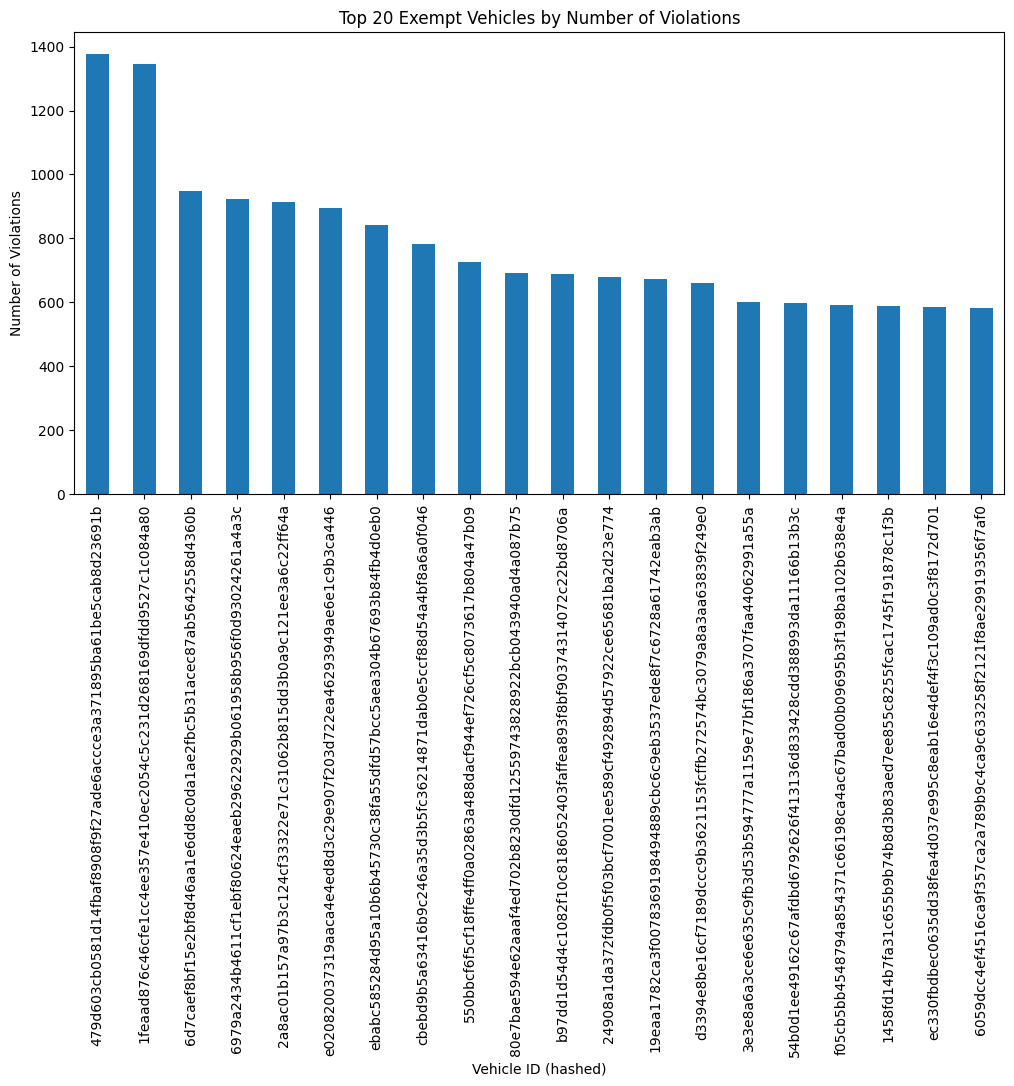

In [ ]:
import matplotlib.pyplot as plt

# count violations per vehicle
vehicle_counts = ACE_exempt_violations['vehicle_id'].value_counts()

# vehicles with more than 1 violation
repeat_offenders = vehicle_counts[vehicle_counts > 1]
print(f"Number of repeat offenders: {len(repeat_offenders)}")
print("Top 10 repeat offenders:")
print(repeat_offenders.head(10))

# top 20 repeat offenders
plt.figure(figsize=(12,6))
repeat_offenders.head(20).plot(kind='bar')
plt.title("Top 20 Exempt Vehicles by Number of Violations")
plt.ylabel("Number of Violations")
plt.xlabel("Vehicle ID (hashed)")
plt.xticks(rotation=90)
plt.show()


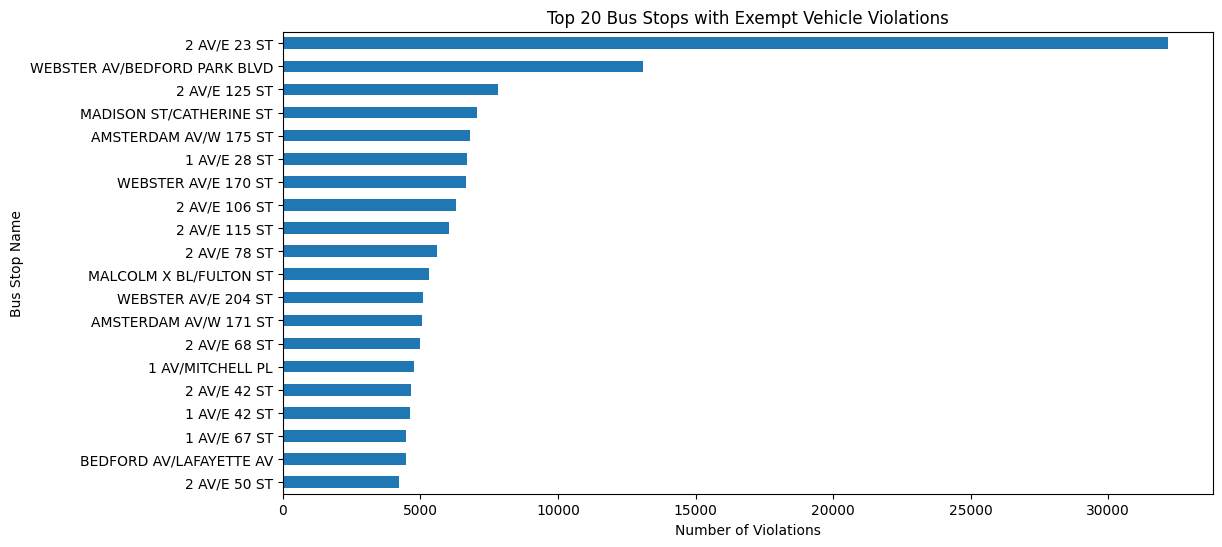

In [ ]:
top_stops = ACE_exempt_violations['stop_name'].value_counts().head(20)

plt.figure(figsize=(12,6))
top_stops.plot(kind='barh')
plt.title("Top 20 Bus Stops with Exempt Vehicle Violations")
plt.xlabel("Number of Violations")
plt.ylabel("Bus Stop Name")
plt.gca().invert_yaxis()
plt.show()


In [20]:
# Get the top stop
top_stop_name = top_stops.index[0]
print(f"Top stop: {top_stop_name}")

# Filter data for this stop
top_stop_data = ACE_exempt_violations[ACE_exempt_violations['stop_name'] == top_stop_name]

# Count violations by bus route at this stop
top_routes = top_stop_data['bus_route_id'].value_counts()
print("Bus routes with most violations at this stop:")
print(top_routes)


Top stop: 2 AV/E 23 ST
Bus routes with most violations at this stop:
bus_route_id
M15+    31561
M14+        1
Name: count, dtype: int64


In [25]:
# import folium
# from IPython.display import display

# bus_route = top_routes.index[0]
# route_data = ACE_exempt_violations[ACE_exempt_violations['bus_route_id'] == bus_route]

# route_map = folium.Map(location=[40.75, -73.98], zoom_start=12)

# # plot violation points
# for idx, row in route_data.iterrows():
#     folium.CircleMarker(
#         location=[row['violation_latitude'], row['violation_longitude']],
#         radius=3,
#         color='red',
#         fill=True
#     ).add_to(route_map)

# # add bus stops along the route
# bus_stops = route_data[['bus_stop_latitude', 'bus_stop_longitude', 'stop_name']].drop_duplicates()
# for idx, row in bus_stops.iterrows():
#     folium.Marker(
#         location=[row['bus_stop_latitude'], row['bus_stop_longitude']],
#         popup=row['stop_name'],
#         icon=folium.Icon(color='blue', icon='info-sign')
#     ).add_to(route_map)

# display(route_map)